In [2]:
import pandas as pd

customers= pd.read_csv('Customers.csv')
products= pd.read_csv('Products.csv')
transactions= pd.read_csv('Transactions.csv')

In [3]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'], errors='coerce')
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'], errors='coerce')

# Merging datasets for unified analysis
merged_data = transactions.merge(customers, on='CustomerID', how='left').merge(products, on='ProductID', how='left')



In [106]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import davies_bouldin_score, silhouette_score
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

encoded_region = pd.get_dummies(merged_data['Region'], prefix='Region')
encoded_category = pd.get_dummies(merged_data['Category'], prefix='Category')


customer_aggregated = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum', 
    'Quantity': 'sum',  
    'ProductID': 'nunique',  
    'Category': lambda x: list(x),  
    'Region': 'first'  
}).reset_index()

customer_aggregated = customer_aggregated.join(
    pd.get_dummies(customer_aggregated['Region'], prefix='Region')
)

# Normalize continuous features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_aggregated[['TotalValue', 'Quantity', 'ProductID']])

# Combine normalized and encoded features
customer_features = np.hstack([scaled_features, customer_aggregated.iloc[:, -len(encoded_region.columns):].values])

cluster_range = range(2,11)
db_scores = []
silhouette_scores = []
cluster_results = {}

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=62)
    cluster_labels = kmeans.fit_predict(customer_features)

    # Calculate clustering metrics
    db_index = davies_bouldin_score(customer_features, cluster_labels)
    silhouette_avg = silhouette_score(customer_features, cluster_labels)
    
    # Store results
    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)
    cluster_results[n_clusters] = {
        "model": kmeans,
        "labels": cluster_labels,
        "db_index": db_index,
        "silhouette_score": silhouette_avg
    }

cluster_results

{2: {'model': KMeans(n_clusters=2, random_state=62),
  'labels': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
         1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
         1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
         1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
         0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
         0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
         1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
         0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
         1]),
  'db_index': 0.9980303295798202,
  'silhouette_score': 0.3781548895750215},
 3: {'model': KMeans(n_clusters=3, random_state=62),
  'labels': array([2, 0, 2, 1, 0, 2, 0, 1, 0, 0, 2, 1, 1, 0, 0, 2, 1, 2, 2, 0, 1, 2,
         2, 2, 0, 2, 2, 1, 0, 2, 

Text(0, 0.5, 'DB Index')

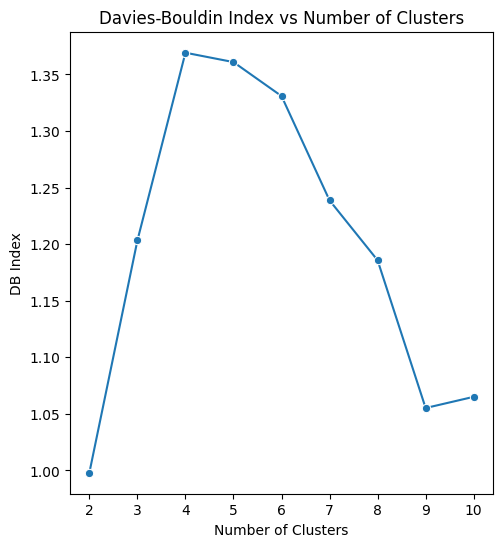

In [100]:
plt.figure(figsize=(12, 6))

# DB Index
plt.subplot(1, 2, 1)
sns.lineplot(x=list(cluster_range), y=db_scores, marker="o")
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")

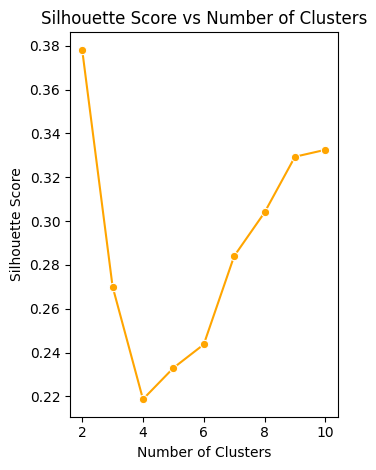

In [96]:
plt.subplot(1, 2, 2)
sns.lineplot(x=list(cluster_range), y=silhouette_scores, marker="o", color="orange")
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

In [108]:
optimal_clusters = cluster_range[np.argmin(db_scores)]
optimal_result = cluster_results[optimal_clusters]

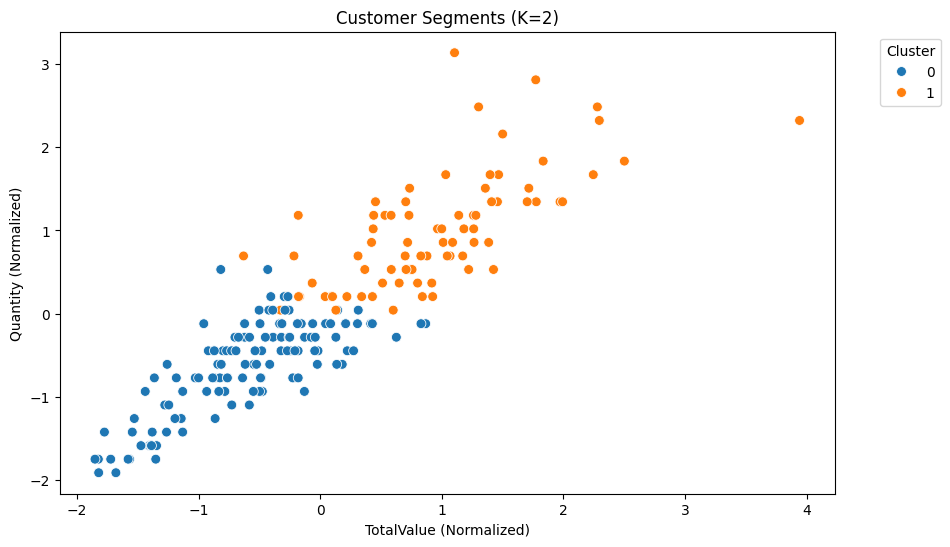

In [111]:
customer_aggregated['Cluster'] = optimal_result['labels']

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=scaled_features[:, 0],  # TotalValue (normalized)
    y=scaled_features[:, 1],  # Quantity (normalized)
    hue=customer_aggregated['Cluster'],
    palette="tab10",
    s=50
)
plt.title(f"Customer Segments (K={optimal_clusters})")
plt.xlabel("TotalValue (Normalized)")
plt.ylabel("Quantity (Normalized)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [113]:
print(f"Optimal number of clusters: {optimal_clusters}")
print(f"DB Index: {optimal_result['db_index']:.4f}")
print(f"Silhouette Score: {optimal_result['silhouette_score']:.4f}")


report = {
    "Optimal Clusters": optimal_clusters,
    "Davies-Bouldin Index": optimal_result['db_index'],
    "Silhouette Score": optimal_result['silhouette_score'],
    "Cluster Distribution": customer_aggregated['Cluster'].value_counts().to_dict()
}

print("\n--- Clustering Report ---")
for key, value in report.items():
    print(f"{key}: {value}")

Optimal number of clusters: 2
DB Index: 0.9980
Silhouette Score: 0.3782

--- Clustering Report ---
Optimal Clusters: 2
Davies-Bouldin Index: 0.9980303295798202
Silhouette Score: 0.3781548895750215
Cluster Distribution: {0: 121, 1: 78}
